Thư viện

In [1]:
%pip install torch torchvision tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

Device: cuda


100%|██████████| 170M/170M [00:18<00:00, 9.32MB/s] 


ViT


**Step 1: Patch Embedding**

In [3]:
class patch_embedding(nn.Module):
    def __init__(self, colors=3, embed_dim=128, patch_size=4):
        super().__init__()
        self.patch = nn.Conv2d(in_channels=colors, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self,x):
        x = self.patch(x)
        x = x.flatten(2) #[Batch,128,8,8] -> [Batch,128,64]
        x = x.transpose(1,2) #[Batch,64,128]
        return x

Ảnh gốc: torch.Size([128, 3, 32, 32])
Sau patch embedding: torch.Size([128, 64, 128])


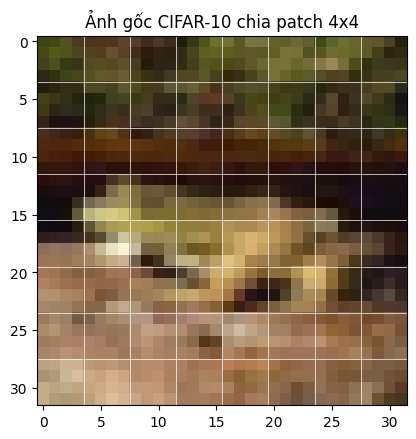

In [8]:
#visualization
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device)

patch_embed = patch_embedding().to(device)
out = patch_embed(imgs)

print("Ảnh gốc:", imgs.shape)
print("Sau patch embedding:", out.shape)

import matplotlib.pyplot as plt
import numpy as np

img = imgs[0].cpu().permute(1,2,0).numpy()
plt.imshow((img * 0.5) + 0.5)
plt.title("Ảnh gốc CIFAR-10 chia patch 4x4")
for i in range(0, 32, 4):
    plt.axhline(i - 0.5, color='white', linewidth=0.5)
for j in range(0, 32, 4):
    plt.axvline(j - 0.5, color='white', linewidth=0.5)
plt.show()


**Step 2: Positional Encoding**

In [5]:
class positional_embedding(nn.Module):
    def __init__(self, embed_dim, num_patch):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, num_patch + 1, embed_dim))
    def forward(self, x):
        return x + self.pos_embed

**Step 3: Transformer Encoder**

In [10]:
#Multi head Attention
class multi_head_attention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
    def forward(self,x):
        return self.attention(x,x,x)[0]

In [11]:
class transformer_encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        #Layer 1
        self.norm1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = multi_head_attention(embed_dim, num_heads)
        #Layer 2
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.LeakyReLUs(),
            nn.Linear(mlp_dim, embed_dim)
        )
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

**Step 4: Vision Transformer**


In [ ]:
class vision_transformer(nn.Module):
    